In [1]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Input, AveragePooling2D, Lambda
from urllib import request
from keras.callbacks import TensorBoard
import tempfile
from keras import optimizers
from keras.utils import Sequence
import numpy as np
from tqdm import tqdm
from datetime import datetime
from keras.applications import vgg16, resnet50
from glob import glob

/home/trule/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Use env variable to detect if run in kaggle environment or not

#!export NOT_KAGGLE_KERNEL=true

In [2]:
NOT_KAGGLE_KERNEL = os.environ.get('NOT_KAGGLE_KERNEL', 'false') == 'true'
print('Run on kaggle kernel:', NOT_KAGGLE_KERNEL)

Run on kaggle kernel: False


# Define variables

In [3]:
ROOT_DIR = '../input/dog-breed' if NOT_KAGGLE_KERNEL else '../input'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')

EPOCHS = 50
BATCH_SIZE = 512
IMAGE_SIZE = (224,224)
INPUT_SHAPE = IMAGE_SIZE + (3,)

# Fetch data (if not exist)

In [4]:
def fetch_data():
    if not os.path.exists(ROOT_DIR):
        os.makedirs(ROOT_DIR)
        zip_path = os.path.join(tempfile.gettempdir(), 'dog-breed.zip')
        print('Start download!')
        request.urlretrieve('https://kienle.blob.core.windows.net/public/kaggle/dog-breed.zip', zip_path)
        print('Start unzip')
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        with zipfile.ZipFile(os.path.join(ROOT_DIR,'test.zip'), 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        with zipfile.ZipFile(os.path.join(ROOT_DIR,'train.zip'), 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        os.remove(zip_path)
        os.remove(os.path.join(ROOT_DIR,'train.zip'))
        os.remove(os.path.join(ROOT_DIR,'test.zip'))
        print('Done')
fetch_data()

In [5]:
# Confirm all data are ready 
# Expected output: labels.csv  sample_submission.csv  test  train
!ls $ROOT_DIR

labels.csv  my_submission.csv  sample_submission.csv  test  train


# Prepare training data set

In [6]:
pd_images = pd.read_csv(os.path.join(ROOT_DIR, 'labels.csv'))

In [7]:
pd_images.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
image_gen = ImageDataGenerator()

In [9]:
train_valid_generator = image_gen.flow_from_dataframe(pd_images, TRAIN_DIR, batch_size=BATCH_SIZE, x_col='id', y_col='breed', has_ext=False, target_size=IMAGE_SIZE)

Found 10222 images belonging to 120 classes.


In [10]:
num_classes = len(train_valid_generator.class_indices)

# Feature extractions using pretrained models

In [11]:
class FeaturesExtractor():
    def __init__(self, input_shape, pretrained_model, preprocess_input):
        self.input_shape = input_shape
        model = pretrained_model(include_top=False, input_shape=self.input_shape, weights='imagenet')
        inputs = Input(self.input_shape)
        x = inputs
        x = Lambda(preprocess_input, name='preprocessing')(x)
        x = model(x)
        x = GlobalAveragePooling2D()(x)
        model = Model(inputs, x)
        self.model = model
    def predict(self, X):
        return self.model.predict(X)
    def predict_generator(self, X):
        return self.model.predict_generator(X)

In [12]:
vgg_features_extractor = FeaturesExtractor(INPUT_SHAPE, vgg16.VGG16, vgg16.preprocess_input)
resnet50_features_extractor = FeaturesExtractor(INPUT_SHAPE, resnet50.ResNet50, resnet50.preprocess_input)

/home/trule/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [13]:
X_train = np.zeros((train_valid_generator.n,) + INPUT_SHAPE)
y_train = np.zeros((train_valid_generator.n, 120))
for i in tqdm(range(len(train_valid_generator)), ncols=100):
    temp_x, temp_y = train_valid_generator[i]
    start_index = i*train_valid_generator.batch_size
    X_train[start_index:start_index + temp_x.shape[0]] = temp_x
    y_train[start_index:start_index + temp_x.shape[0]] = temp_y


100%|███████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


In [14]:
def create_simple_model(num_classes, input_shape):
    inputs = Input(input_shape)
    x = inputs
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, x)


# Use vgg16

In [15]:
# Calculate vgg features
vgg_features = vgg_features_extractor.predict(X_train)

In [16]:
vgg_based_model = create_simple_model(num_classes, vgg_features_extractor.model.output.get_shape().as_list()[1:])
vgg_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
if NOT_KAGGLE_KERNEL:
    callbacks = [TensorBoard('./data/logs/vgg-{0}'.format(datetime.now().isoformat().replace(':','-').split('.')[0]))]
else:
    callbacks = []
    
vgg_based_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 61,560
Trainable params: 61,560
Non-trainable params: 0
_________________________________________________________________


In [17]:
vgg_based_model.fit(vgg_features, y_train, batch_size=256, epochs=EPOCHS, callbacks=callbacks, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 1s 107us/step - loss: 14.8751 - acc: 0.0193 - val_loss: 13.1643 - val_acc: 0.0557
Epoch 2/50
9199/9199 [==============================] - 0s 11us/step - loss: 13.8951 - acc: 0.0449 - val_loss: 10.7769 - val_acc: 0.1134
Epoch 3/50
9199/9199 [==============================] - 0s 11us/step - loss: 12.5326 - acc: 0.0859 - val_loss: 9.1578 - val_acc: 0.2151
Epoch 4/50
9199/9199 [==============================] - 0s 11us/step - loss: 11.2334 - acc: 0.1378 - val_loss: 7.5774 - val_acc: 0.2991
Epoch 5/50
9199/9199 [==============================] - 0s 10us/step - loss: 9.8059 - acc: 0.1942 - val_loss: 6.3195 - val_acc: 0.3861
Epoch 6/50
9199/9199 [==============================] - 0s 11us/step - loss: 8.7370 - acc: 0.2423 - val_loss: 5.3871 - val_acc: 0.4076
Epoch 7/50
9199/9199 [==============================] - 0s 11us/step - loss: 7.7808 - acc: 0.2900 - val_loss: 4.7715 - val_acc: 0.4682


# Use resnet50

In [18]:
resnet50_features = resnet50_features_extractor.predict(X_train)

In [19]:
resnet50_based_model = create_simple_model(num_classes, resnet50_features_extractor.model.output.get_shape().as_list()[1:])
resnet50_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
if NOT_KAGGLE_KERNEL:
    callbacks = [TensorBoard('./data/logs/resnet50-{0}'.format(datetime.now().isoformat().replace(':','-').split('.')[0]))]
else:
    callbacks = []

In [20]:
resnet50_based_model.fit(resnet50_features, y_train, batch_size=256, epochs=EPOCHS,  callbacks=callbacks, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 1s 97us/step - loss: 3.9218 - acc: 0.1719 - val_loss: 1.7734 - val_acc: 0.5738
Epoch 2/50
9199/9199 [==============================] - 0s 13us/step - loss: 1.6698 - acc: 0.5465 - val_loss: 1.1182 - val_acc: 0.6950
Epoch 3/50
9199/9199 [==============================] - 0s 12us/step - loss: 1.1593 - acc: 0.6721 - val_loss: 0.9727 - val_acc: 0.7224
Epoch 4/50
9199/9199 [==============================] - 0s 12us/step - loss: 0.9187 - acc: 0.7303 - val_loss: 0.9044 - val_acc: 0.7351
Epoch 5/50
9199/9199 [==============================] - 0s 12us/step - loss: 0.7735 - acc: 0.7758 - val_loss: 0.8445 - val_acc: 0.7429
Epoch 6/50
9199/9199 [==============================] - 0s 13us/step - loss: 0.6707 - acc: 0.8090 - val_loss: 0.8075 - val_acc: 0.7537
Epoch 7/50
9199/9199 [==============================] - 0s 13us/step - loss: 0.5925 - acc: 0.8227 - val_loss: 0.8121 - val_acc: 0.7546
Epoch 8

# Confusion matrix (VGG)

In [21]:
index2labels = {}
for k, v in train_valid_generator.class_indices.items():
    index2labels[v] = k

In [22]:
preds = []
targets = []
for i in tqdm(range(len(train_valid_generator)), ncols=100):
    x, y = train_valid_generator[i]
    p = vgg_based_model.predict(vgg_features_extractor.predict(x))
    p = np.argmax(p, axis=1)    
    y = np.argmax(y, axis=1)
    preds = np.concatenate((preds, p))
    targets = np.concatenate((targets, y))
from sklearn.metrics import confusion_matrix
print(np.sum(targets == preds))
print(preds[0:10])
print(targets[0:10])
cm = confusion_matrix(targets, preds)
print(cm[0:10, 0:10])

100%|███████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.11s/it]


9100
[ 50.  99.  55.  21. 104.  90.  52.  86. 103.  44.]
[ 50.  99. 116.  21. 104.  35.  52.  68. 103.  44.]
[[ 84   0   0   0   0   0   0   0   0   0]
 [  0  73   0   0   0   0   0   2   0   0]
 [  0   0  69   0   0   0   0   0   0   0]
 [  0   0   0  80   0   0   0   0   0   0]
 [  0   0   0   0  60   0   1   0   0   0]
 [  0   0   0   0   0  88   0   0   0   0]
 [  0   0   0   0   0   0  72   0   0   0]
 [  0   0   0   0   0   0   0 108   0   0]
 [  0   0   0   0   0   0   1   0 108   0]
 [  0   0   0   0   0   0   0   0   0  66]]


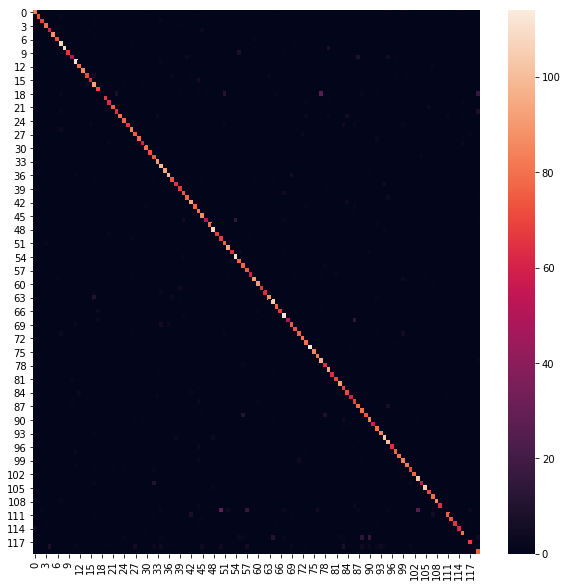

In [23]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=False)

# Prepare submission data

In [24]:
pd_test = pd.DataFrame(glob(TEST_DIR +'/*.jp*g'), columns=['filename'])
test_generator = image_gen.flow_from_dataframe(pd_test, TEST_DIR,  class_mode=None, target_size=IMAGE_SIZE, shuffle=False)

Found 10357 images.


In [25]:
test_resnet_features = resnet50_features_extractor.predict_generator(test_generator)

In [26]:
type(test_resnet_features)

numpy.ndarray

In [27]:
test_probs = resnet50_based_model.predict(test_resnet_features)

In [28]:
pd_sub = pd.read_csv(os.path.join(ROOT_DIR, 'sample_submission.csv'))

In [29]:
sub_mission = pd.DataFrame(test_probs, index=pd_sub.index, columns=pd_sub.columns[1:])
sub_mission['id'] = pd_sub['id']
sub_mission_cols = sub_mission.columns.tolist()
sub_mission = sub_mission[sub_mission_cols[-1:] + sub_mission_cols[:-1]]

In [30]:
sub_mission.to_csv(os.path.join(ROOT_DIR, 'my_submission.csv'), index=False)